# TP Question 3

Dans cette troisième partie, on s'intéresse à l'étude des options à barrière. Le payoff dépend du prix du sous-jaçent à l'expiration de l'option ainsi que de conditions sur les extremum atteints par le sous-jaçent pendant toute la durée de l'option. On se concentre sur deux types d'options à barrière : 
 - L'option up-and-out : si le sous-jaçent franchi une valeur barrière à la hausse, l'option est annulée, son prix chûte à 0
 - L'option down-and-in : l'option n'est activée que si le sous-jaçent franchit une valeur barrière à la baisse

On distinguera deux types d'options up-and-out : 
 - Surveillance discrète : l'option n'est annulée que si le sous-jaçent se trouve au-dessus de la barrière à des instants déterminés à l'avance
 - Surveillance continue : l'option est annulée dès que le sous-jaçent franchit la barrière

Pour les 3 catégories d'options, le payoff dépend du chemin suivi et vaut : 
 - Up-and-out à surveillance discrète :$(S_T-K)_+ \mathbb{1}_{max(S_{t_1},...,S_{t_n}) < L}$
 - Up-and-out à surveillance continue :$(S_T-K)_+ \mathbb{1}_{max S_t < L}$
 - Down-and-in                        :$(S_T-K)_+ \mathbb{1}_{min S_t < B}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
####################################################################################################################
################################### VARIABLES GLOBALES UTILISEES POUR CETTE QUESTION ####################################
####################################################################################################################
t = 0
K = 80
T= 1
sigma = 0.08
r = 0.02
n_sim = 10**4
n_obs = 10
M = 90
S0 = 78
alpha = 0.95

#  Call up-and-out 


## surveillance discrète

La valeur d'un call à barrière désactivante avec monitoring discret vaut à la date t : 
$$
C_t = \mathbb{E}^Q \left(e^{-r(t-T)}\left((S_T - K)_+ \mathbb{1}_{max(S_{t_1},...,S_{t_n})<L}\right)_+|\mathcal{F}_t\right)
$$

On simule une trajectoire de l'actif risqué sur l'intervalle $[0,T]$ et on compare l'évolution du prix du call à barrière désactivante avec monitoring discret avec celui du call européen.

In [3]:
## Calcule le prix du call européen à la date t lorsque le sous-jaçent vaut S_t à l'aide de la formule de Black-Scholes.
    
def Price_BS(S,K,T,r,sigma,t=0): 
    d1 = (np.log(S/K)+(r+sigma**2/2.)*(T-t))/(sigma*np.sqrt(T-t)) 
    
    d2 = d1-sigma*np.sqrt(T-t)
    return S*norm.cdf(d1)-K*np.exp(-r*(T-t))*norm.cdf(d2)

In [4]:
def up_out_discret(S0,K,T,r,sigma,M,n_obs,n_sim=n_sim,alpha=0.95):

    delta_t = T/n_obs
    
    Z = np.random.randn(n_sim,n_obs)
    
    S = S0*np.cumprod(np.exp((r - 0.5*sigma**2)*(delta_t) + sigma*np.sqrt(delta_t)*Z),axis=1)
    
    max_S = np.max(S,axis=1)

    payoff = np.exp(-r*T)*np.maximum(S[:,-1]-K,0)

    payoff[max_S>M] = 0
    
    price  = np.mean(payoff)
    
    var = np.var(payoff)
    
    q_alpha   = norm.ppf(1 - (1-alpha)/2)
    
    borne_sup  = price + q_alpha*np.sqrt(var/n_sim)
    borne_inf = price - q_alpha*np.sqrt(var/n_sim)
    
    return [price,borne_sup,borne_inf]

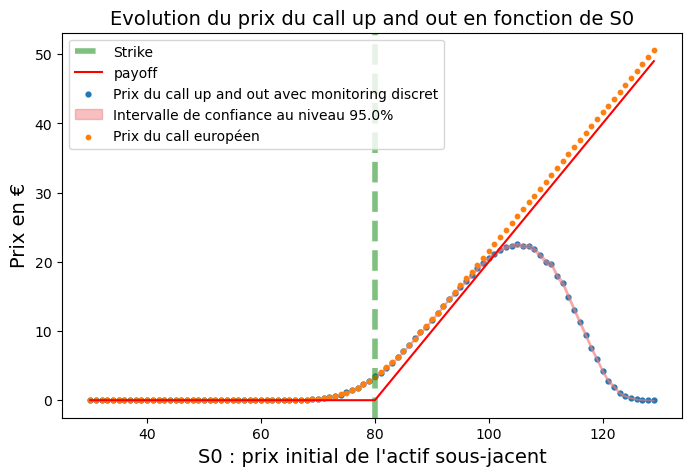

In [5]:
t = 0
K = 80
T= 1
sigma = 0.08
r = 0.02
n_sim = 10**4
n_obs = 10
M = 120
S0 = 78
alpha=0.95

list_S0 = [K+i for i in range(-50,50)]

[C_discret,borne_sup,borne_inf] = np.array([up_out_discret(S0,K,T,r,sigma,M,n_obs,n_sim=n_sim,alpha=0.95) for S0 in list_S0]).T
C_BS = [Price_BS(S0,K,T,r,sigma) for S0 in list_S0]

plt.figure(figsize=(8,5))
plt.axvline(x=K, ymin=0, ymax=1, color='green', alpha=0.5, linestyle='--', linewidth=4, label='Strike')
dr = [0 if i<K else i-K for i in list_S0]

plt.plot(list_S0,dr,color="red",label="payoff")
plt.scatter(list_S0, C_discret,label='Prix du call up and out avec monitoring discret',s=12)
plt.fill_between(list_S0, borne_inf, borne_sup, color="lightcoral", alpha=0.5, label="Intervalle de confiance au niveau " + str(alpha * 100) + "%")

plt.scatter(list_S0,C_BS,label="Prix du call européen",s=10)

plt.ylabel('Prix en €',fontsize=14)
plt.xlabel("S0 : prix initial de l'actif sous-jacent",fontsize=14)
plt.title("Evolution du prix du call up and out en fonction de S0",fontsize=14)
plt.legend()

###### Commentaire


Si $S_0$ est inférieur à un seuil, une augmentation de $S_0$ affecte l'option up-and-out comme un call européen. Si $S_0$ est proche du strike, le prix et sa dérivée augmentent, sinon le prix reste nul.

Cependant, contrairement au call européen où le prix augmente indéfiniment, le prix de l'option up-and-down chute si $S_0$ dépasse le seuil, car cela augmente la probabilité de franchir la barrière et annuler l'option.



## évolution du prix de l’option d’achat à barrière up-and-out discrète quand le nombre de dates d’observation augmente

La valeur d'un call à barrière désactivante avec monitoring continue vaut à la date t : 
$$
C_t = \mathbb{E}^Q \left(e^{-r(t-T)}\left((S_T - K)_+ \mathbb{1}_{max(S_t)<L}\right)_+|\mathcal{F}_t\right)
$$


In [6]:
def up_out_continu(S0,K,T,r,sigma,M,n_sim=n_sim,alpha=0.95):
    n_sim2 = 500

    BT = np.random.normal(0, 1, n_sim)
    ST = S0*np.exp((r - 0.5*sigma**2)*(T) + sigma*np.sqrt(T)*BT)
    
    max_BT = 0.5 * (BT + np.sqrt(BT**2 - 2*T* np.log(np.random.rand(n_sim2,n_sim))))
    max_ST = S0 * np.mean(np.exp(sigma * max_BT),axis=0)
        
    payoff = np.exp(-r*T)*np.maximum(ST-K,0)
    payoff[max_ST>M] = 0
    
    price  = np.mean(payoff)
    
    var = np.var(payoff)
    
    q_alpha   = norm.ppf(1 - (1-alpha)/2)
    
    borne_sup  = price + q_alpha*np.sqrt(var/n_sim)
    borne_inf = price - q_alpha*np.sqrt(var/n_sim)
    
    return [price,borne_sup,borne_inf]

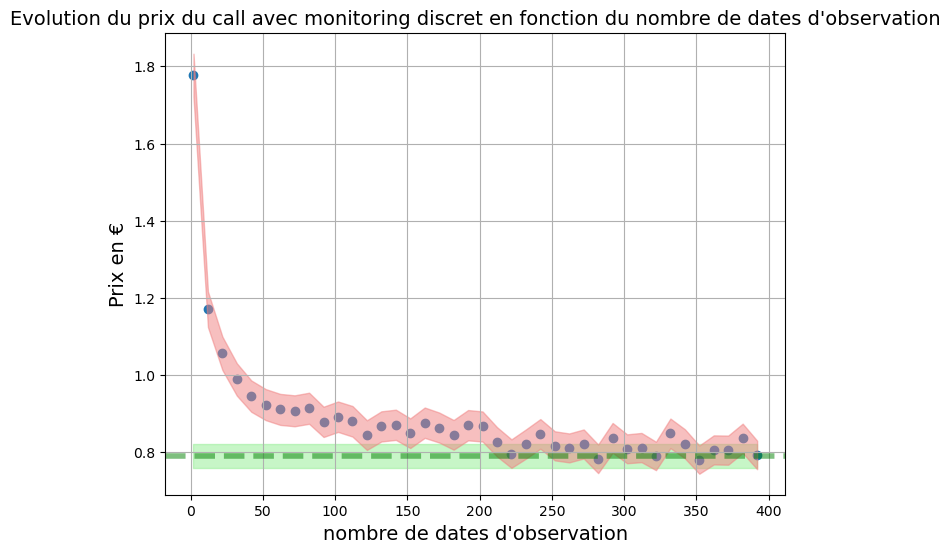

In [7]:
t = 0
K = 80
T= 1.5
sigma = 0.08
r = 0.02
n_sim = 10**4
n_obs = 10
M = 90
S0 = 85
alpha = 0.95

n_obs_list = list(range(2,400,10))
[C_discret,borne_sup,borne_inf] = np.array([up_out_discret(S0,K,T,r,sigma,M,n_obs,n_sim=n_sim,alpha=0.95) for n_obs in n_obs_list]).T

C_continu,b_sup,b_inf = up_out_continu(S0,K,T,r,sigma,M)

plt.figure(figsize=(8,6))

plt.axhline(y=C_continu, color='green', alpha=0.5, linestyle='--', linewidth=4, label='monitoring continu')
plt.fill_between(n_obs_list, b_inf, b_sup, color="lightgreen", alpha=0.5, label="Intervalle de confiance au niveau " + str(alpha * 100) + "%")


plt.scatter(n_obs_list,C_discret)
plt.fill_between(n_obs_list, borne_inf, borne_sup, color="lightcoral", alpha=0.5, label="Intervalle de confiance au niveau " + str(alpha * 100) + "%")


plt.xlabel("nombre de dates d'observation",fontsize=14)
plt.ylabel("Prix en €",fontsize=14)
plt.title("Evolution du prix du call avec monitoring discret en fonction du nombre de dates d'observation",fontsize=14)
plt.grid()

##### Commentaire

L'augmentation du nombre de dates de surveillance fait baisser le prix de l'option jusqu'à se rapprocher de la valeur de l'option up-and-out avec monitoring continu. La dynamique des prix avec monitoring discrets converge vers la dynamique des prix avec monitoring continu lorsque le nombre de dates augmente.

## le prix de l’option d’achat à barrière down-and-in

on s'intéresse à l'option down-and-in avec monitoring continu. Pour le call up-and-out avec monitoring continu, les simulations de Monte-Carlo étaient efficaces car nous disposions d'un moyen de simuler le maximum atteint par le sous-jaçent sur $[0,T]$ sachant sa valeur en $t=T$.

On réplique donc le même raisonnement afin de conserver cette efficacité. En notant $M_t = inf_{0 \leq s \leq t} B_s$ le minimum courant du mouvement brownien, on trouve : 
$$
f_{M,B}(m,b) = \frac{2(2m-b)}{t \sqrt{2 \pi t}}e^{-\frac{(2m-b)^2}{2t}} \mathbb{1}_{\Delta}(m,b), \quad avec \; \Delta = \{(m,b) \in \mathbb{R}^2 : m \leq 0, b \geq m\}
$$

A l'indicatrice près, la densité est la même que dans le cas de l'option up-and-out. De manière analogue, on détermine la densité conditionnelle de $M_t^X$ sachant $X_t=x$ et enfin on en déduit une procédure de simulation similaire : 
$$
Si \; U \sim U(0,1), \; \frac{x - \sqrt{x^2 - 2Tlog(U)}}{2} \sim M_T^X \; sachant \; X_T = x
$$


In [8]:
def down_in_continu(S0,K,T,r,sigma,M,n_sim=n_sim,alpha=0.95):
    n_sim2 = 1000

    BT = np.random.normal(0, 1, n_sim)
    ST = S0*np.exp((r - 0.5*sigma**2)*(T) + sigma*np.sqrt(T)*BT)
    
    min_BT = 0.5 * (BT - np.sqrt(BT**2 - 2*T* np.log(np.random.rand(n_sim2,n_sim))))
    min_ST = S0 * np.mean(np.exp(sigma * min_BT),axis=0)
        
    payoff = np.exp(-r*T)*np.maximum(ST-K,0)
    payoff[min_ST>M] = 0
    
    price  = np.mean(payoff)
    
    var = np.var(payoff)
    
    q_alpha   = norm.ppf(1 - (1-alpha)/2)
    
    borne_sup  = price + q_alpha*np.sqrt(var/n_sim)
    borne_inf = price - q_alpha*np.sqrt(var/n_sim)
    
    return [price,borne_sup,borne_inf]

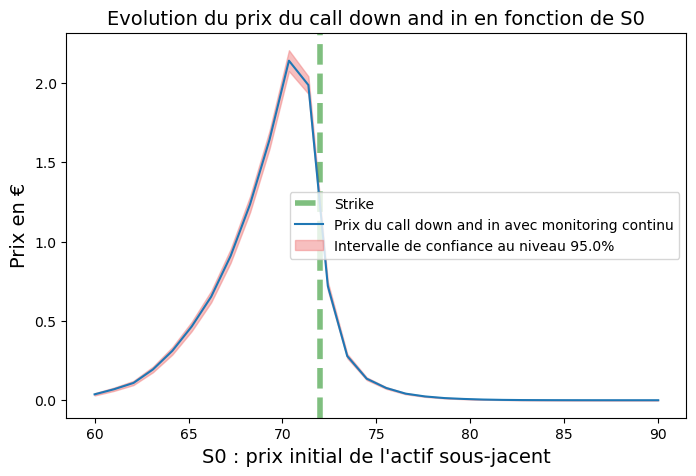

In [9]:
t = 0
K = 72
T= 1
sigma = 0.08
r = 0.02
n_sim = 10**3
L = 70
S0 = 78
alpha=0.95

list_S0 = np.linspace(60,90,30)

[C,borne_sup,borne_inf] = np.array([down_in_continu(S0,K,T,r,sigma,L,alpha=0.95) for S0 in list_S0]).T


plt.figure(figsize=(8,5))
plt.axvline(x=K, ymin=0, ymax=1, color='green', alpha=0.5, linestyle='--', linewidth=4, label='Strike')

plt.plot(list_S0, C,label='Prix du call down and in avec monitoring continu')
plt.fill_between(list_S0, borne_inf, borne_sup, color="lightcoral", alpha=0.5, label="Intervalle de confiance au niveau " + str(alpha * 100) + "%")


plt.ylabel('Prix en €',fontsize=14)
plt.xlabel("S0 : prix initial de l'actif sous-jacent",fontsize=14)
plt.title("Evolution du prix du call down and in en fonction de S0",fontsize=14)
plt.legend()

## Monte carlo conditionnel

In [10]:
def down_in_discret_MC_conditionnel(S0,K,T,r,sigma,L,n_obs,n_sim=n_sim,alpha=0.95):
    
    delta_t = T/n_obs
    
    Z = np.random.randn(n_sim,n_obs)
    #print(np.mean(np.max(Z,axis=1)))
    
    S = S0*np.cumprod(np.exp((r - 0.5*sigma**2)*(delta_t) + sigma*np.sqrt(delta_t)*Z),axis=1)
    
    knock_index = np.argmax(S<L,axis=1)

    payoff = np.exp(-r*T)*np.maximum(S[:,-1]-K,0)
    
    payoff[knock_index>0] =  Price_BS(S[knock_index>0,knock_index[knock_index>0]],K,T,r,sigma,t=(T/n_obs)*knock_index[knock_index>0])
    

    
    ## calcul de std
    
    variance=[0]
    d = 0
    m = payoff[0]
    for i in range(1,n_sim):
        delta = payoff[i]-m
        m=m+delta/(i+1)
        d=d+(i/(i+1))*delta**2
        variance.append(d/i)
    
    ## Confidence interval
    price = np.cumsum(payoff) / np.array([(i+1) for i in range(n_sim)])
    
    q_alpha = norm.ppf(1 - (1-alpha)/2)
    borne = q_alpha*np.sqrt(variance / np.array([(i+1) for i in range(n_sim)]))   
    conf_min = price - borne
    conf_max = price + borne
    
    return price[1:],conf_min[1:],conf_max[1:],variance[1:]

In [11]:
def down_in_discret_MC(S0,K,T,r,sigma,M,n_obs,n_sim=n_sim,alpha=0.95):

    delta_t = T/n_obs
    
    Z = np.random.randn(n_sim,n_obs)
    
    S = S0*np.cumprod(np.exp((r - 0.5*sigma**2)*(delta_t) + sigma*np.sqrt(delta_t)*Z),axis=1)
    
    min_S = np.min(S,axis=1)

    payoff = np.exp(-r*T)*np.maximum(S[:,-1]-K,0)

    payoff[min_S>M] = 0

    
     ## calcul de std
    
    variance=[0]
    d = 0
    m = payoff[0]
    for i in range(1,n_sim):
        delta = payoff[i]-m
        m=m+delta/(i+1)
        d=d+(i/(i+1))*delta**2
        variance.append(d/i)
    
    ## Confidence interval
    price = np.cumsum(payoff) / np.array([(i+1) for i in range(n_sim)])
    
    q_alpha = norm.ppf(1 - (1-alpha)/2)
    borne = q_alpha*np.sqrt(variance / np.array([(i+1) for i in range(n_sim)]))   
    conf_min = price - borne
    conf_max = price + borne
    
    return price[1:],conf_min[1:],conf_max[1:],variance[1:]

## Analyse de la réduction de variance de l’estimateur de Monte Carlo conditionnel pour un call Down  and In

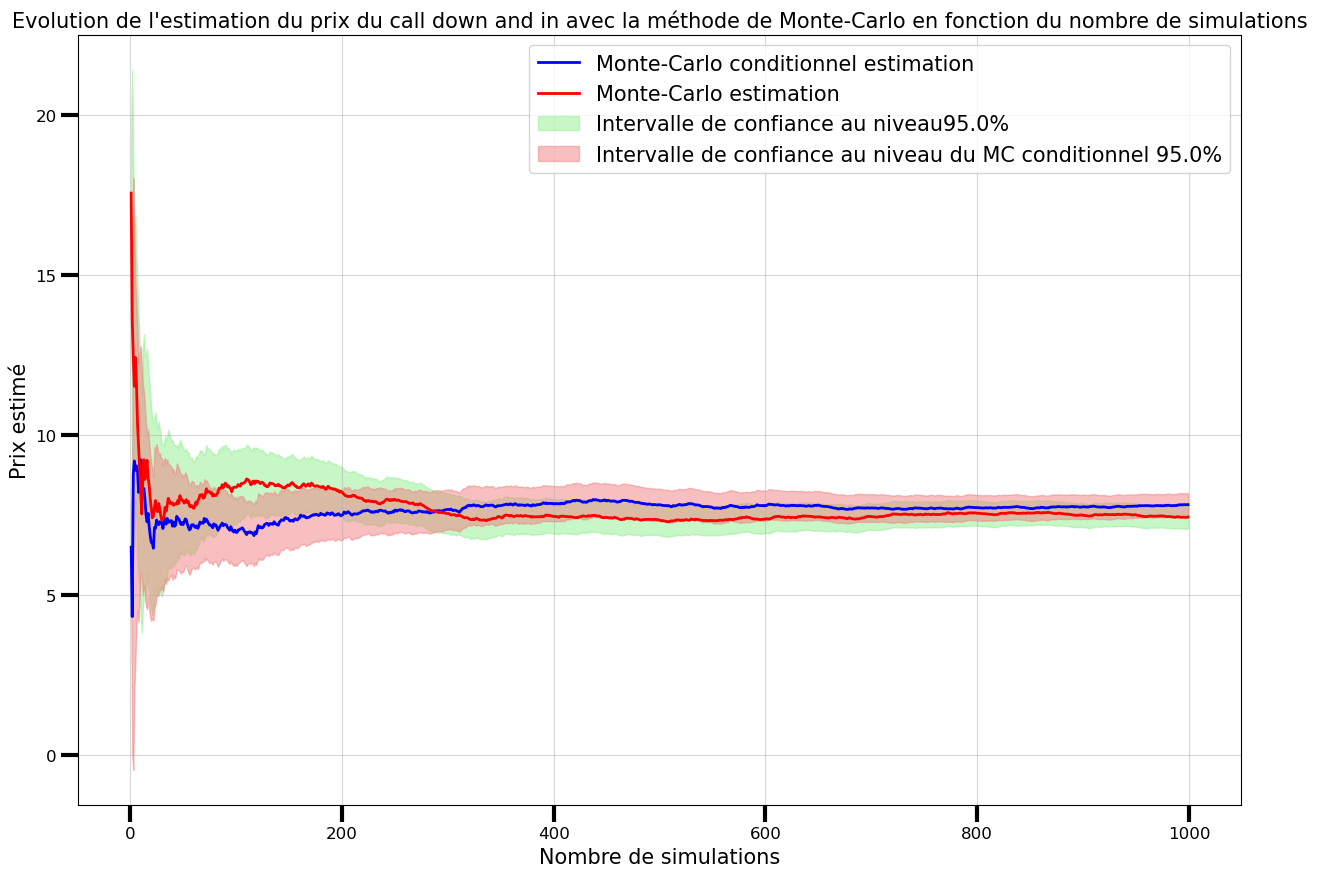

In [12]:
L=100
price,conf_min,conf_max,variance = down_in_discret_MC_conditionnel(S0,K,T,r,sigma,L,n_obs,n_sim=n_sim,alpha=0.95)


price1,conf_min1,conf_max1,variance1 =down_in_discret_MC(S0,K,T,r,sigma,M,n_obs,n_sim=n_sim,alpha=0.95)

iterations = [i for i in range(1,n_sim)]

## figure
plt.figure(4,figsize=(15,10))
plt.plot(iterations, price, color="blue", label="Monte-Carlo conditionnel estimation", linewidth = 2)

plt.plot(iterations, price1, color="red", label="Monte-Carlo estimation", linewidth = 2)


plt.fill_between(iterations, conf_min1, conf_max1, color="lightgreen", alpha=0.5, label="Intervalle de confiance au niveau" + str(0.95 * 100) + "%")

plt.fill_between(iterations, conf_min, conf_max, color="lightcoral", alpha=0.5, label="Intervalle de confiance au niveau du MC conditionnel " + str(0.95 * 100) + "%")
plt.title("Evolution de l'estimation du prix du call down and in avec la méthode de Monte-Carlo en fonction du nombre de simulations", fontsize=15)
plt.legend(fontsize=15)
plt.grid()
axes = plt.gca()
axes.tick_params(direction='out', length=12, width=3, labelsize=8, grid_alpha=0.5)
axes.set_xlabel('Nombre de simulations', fontsize=15)
axes.set_ylabel('Prix estimé', fontsize=15)
for tickLabel in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tickLabel.set_fontsize(12)

Text(0, -5, 'Pente calculée  = -0.5')

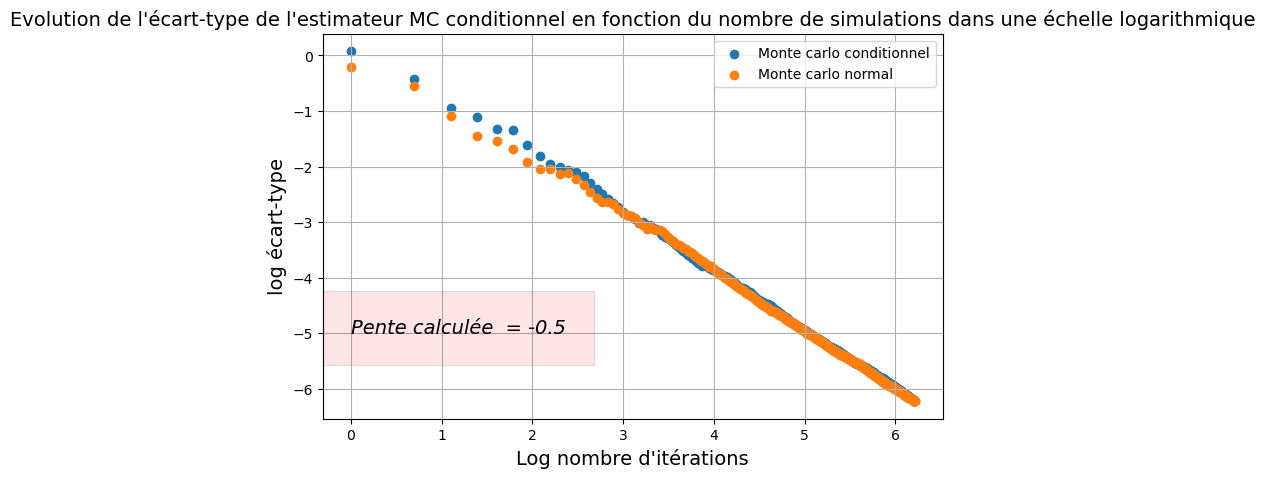

In [18]:
n_obs = 10
n_sim=500
var = []
pr=[]

var1 = []
pr1=[]


## on moyenne les résultats sur plusieurs estimations afin de lisser les courbes 
for i in range(200):
    
    price,conf_min,conf_max,variance = down_in_discret_MC_conditionnel(S0,K,T,r,sigma,100,n_obs,n_sim=n_sim,alpha=0.95)
    price1,conf_min1,conf_max1,variance1 =down_in_discret_MC(S0,K,T,r,sigma,M,n_obs,n_sim=n_sim,alpha=0.95)

    var.append(variance)
    pr.append(price)
    
    var1.append(variance1)
    pr1.append(price1)

v = np.mean(np.array(var),axis=0)/ np.array(list(range(1,n_sim)))
ecart_type = np.sqrt(v)
iterations = [i for i in range(1,n_sim)]

v1 = np.mean(np.array(var1),axis=0)/ np.array(list(range(1,n_sim)))
ecart_type1 = np.sqrt(v1)




slope, intercept = np.polyfit(np.log(iterations),np.log(ecart_type),1)
    

plt.figure(figsize=(8,5))
plt.scatter(np.log(iterations),np.log(v),label="Monte carlo conditionnel")
plt.scatter(np.log(iterations),np.log(v1),label='Monte carlo normal')
plt.ylabel('log écart-type',fontsize=14)
plt.xlabel("Log nombre d'itérations", fontsize=14)
plt.grid()
plt.legend()
plt.title("Evolution de l'écart-type de l'estimateur MC conditionnel en fonction du nombre de simulations dans une échelle logarithmique", fontsize=14)

textstr = 'Pente calculée  = '+str(round(slope,1))

plt.text(0, -5, textstr, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.1, 'pad': 20},fontsize=14)

## la somme du prix du call up-and-in et du call up-and-out.

In [14]:
def up_in_continu(S0,K,T,r,sigma,M,n_sim=n_sim,alpha=0.95):
    n_sim2 = 500

    BT = np.random.normal(0, 1, n_sim)
    ST = S0*np.exp((r - 0.5*sigma**2)*(T) + sigma*np.sqrt(T)*BT)
    
    max_BT = 0.5 * (BT + np.sqrt(BT**2 - 2*T* np.log(np.random.rand(n_sim2,n_sim))))
    max_ST = S0 * np.mean(np.exp(sigma * max_BT),axis=0)
        
    payoff = np.exp(-r*T)*np.maximum(ST-K,0)
    payoff[max_ST<M] = 0
    
    price  = np.mean(payoff)
    
    var = np.var(payoff)
    
    q_alpha   = norm.ppf(1 - (1-alpha)/2)
    
    borne_sup  = price + q_alpha*np.sqrt(var/n_sim)
    borne_inf = price - q_alpha*np.sqrt(var/n_sim)
    
    return [price,borne_sup,borne_inf]

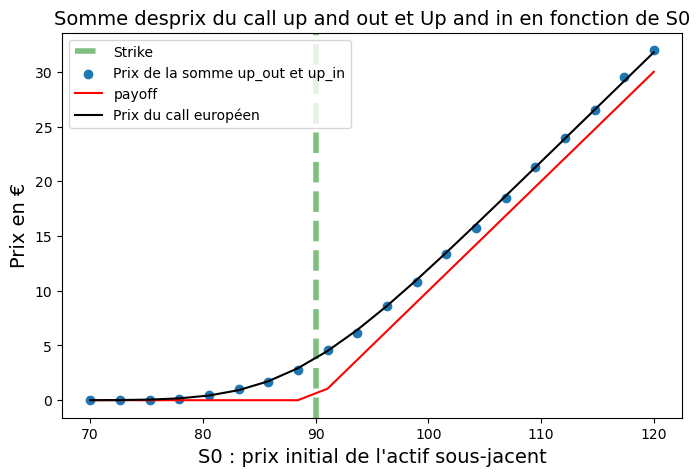

In [15]:
K = 90
list_S0 = np.linspace(70,120,20)

[C_in,borne_sup_in,borne_inf_in] = np.array([up_in_continu(S0,K,T,r,sigma,M,n_sim=1000,alpha=0.95) for S0 in list_S0]).T

[C_out,borne_sup_out,borne_inf_out] = np.array([up_out_continu(S0,K,T,r,sigma,M,n_sim=1000) for S0 in list_S0]).T



C_BS = [Price_BS(S0,K,T,r,sigma) for S0 in list_S0]
dr = [0 if i<K else i-K for i in list_S0]

plt.figure(figsize=(8,5))
plt.axvline(x=K, ymin=0, ymax=1, color='green', alpha=0.5, linestyle='--', linewidth=4, label='Strike')

plt.scatter(list_S0, C_in+C_out,label='Prix de la somme up_out et up_in')


plt.plot(list_S0,dr,color="red",label="payoff")

plt.plot(list_S0,C_BS,label="Prix du call européen",color='black')



plt.ylabel('Prix en €',fontsize=14)
plt.xlabel("S0 : prix initial de l'actif sous-jacent",fontsize=14)
plt.title("Somme desprix du call up and out et Up and in en fonction de S0",fontsize=14)
plt.legend()

#### Commentaire
Le call up and in est une option qui a un payoff si le sous-jacent atteint une barrière déterminée. Le call up and out a un payoff si le sous-jacent ne dépasse pas cette barrière. En somme, le call up and in paie si le sous-jacent atteint la barrière, tandis que le call up and out paie si le sous-jacent ne dépasse pas la barrière.

Le call européen standard, quant à lui, a un payoff si le sous-jacent atteint un niveau d'exercice déterminé. Il est possible de décomposer ce payoff en deux parties : une partie correspondant au cas où le sous-jacent atteint la barrière et une partie correspondant au cas où le sous-jacent ne dépasse pas la barrière.

Ainsi, la somme du prix du call up and in et du call up and out donne le prix d'un call européen standard, car ces deux options couvrent les deux cas de payoffs qui définissent un call européen standard. C'est pour cette raison que la somme du prix du call up and in et du call up and out donne le prix d'un call européen standard.